<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/newLosses_Lucia/ICaRLMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [ ]:
import os
import logging
import sys

In [ ]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b newLosses_Lucia https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 1280 (delta 116), reused 26 (delta 25), pack-reused 1112
Receiving objects: 100% (1280/1280), 837.93 KiB | 2.23 MiB/s, done.
Resolving deltas: 100% (816/816), done.


# Import packages

In [ ]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from DatasetCIFAR import ICaRLModel
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np

from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

# Define Datasets

In [ ]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainDS = Dataset(train=True, transform = train_transformer)
testDS = Dataset(train=False, transform = test_transformer)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [ ]:
train_splits = trainDS.splits
test_splits = testDS.splits

# Define Network

In [ ]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [ ]:
exemplars = [None]*100

test_indexes =  []

In [ ]:
for task in range(0, 100, params.TASK_SIZE):
  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes)
  test_dataset = Subset(testDS, test_indexes)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE )

  ICaRL, exemplars = ICaRLModel.incrementalTrain(task, trainDS, ICaRL, exemplars)

  col = []
  for i,x in enumerate( train_splits[ :int(task/10) + 1]) : 
    v = np.array(x)
    col = np.concatenate( (col,v), axis = None)
    col = col.astype(int)
  mean = None
  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in train_loader:
      img = img.float().to(params.DEVICE)
      preds, mean = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)
      #print("preds: ", preds.data)
      #print("mapped labels: ", labels)
      #print("labels: ", lbl)
      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()
      #print(running_corrects)
  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'train accuracy = {accuracy}')

  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in test_loader:
      img = img.float().to(params.DEVICE)
      preds, _ = ICaRLModel.classify(img, exemplars, ICaRL, task, trainD0S, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)
      #print("preds: ", preds.data)
      #print("mapped labels: ", labels)
      #print("labels: ", lbl)
      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()
      #print(running_corrects)
  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'test accuracy = {accuracy}')

col =  [94 63 74 21 35 56 91 96 87 48]
col[:10] [94 63 74 21 35 56 91 96 87 48]
At step  0  and at epoch =  0  the loss is =  0.017890598624944687  and accuracy is =  0.1006
At step  0  and at epoch =  1  the loss is =  0.01488502137362957  and accuracy is =  0.1282
At step  0  and at epoch =  2  the loss is =  0.009532357566058636  and accuracy is =  0.226
At step  0  and at epoch =  3  the loss is =  0.007302583660930395  and accuracy is =  0.3414
At step  0  and at epoch =  4  the loss is =  0.00843354407697916  and accuracy is =  0.3916
At step  0  and at epoch =  5  the loss is =  0.010823175311088562  and accuracy is =  0.4224
At step  0  and at epoch =  6  the loss is =  0.010508752427995205  and accuracy is =  0.4638
At step  0  and at epoch =  7  the loss is =  0.007418529596179724  and accuracy is =  0.4786
At step  0  and at epoch =  8  the loss is =  0.0068102809600532055  and accuracy is =  0.4928
At step  0  and at epoch =  9  the loss is =  0.007457822561264038  and accu

In [ ]:
l = [0.745,  0.397, 0.412, 0.292, 0.2038,0.1635, 0.151, 0.107, 0.068, 0.0723 ]

In [ ]:
def plotTask(pars_tasks):
  import numpy as np
  import matplotlib.pyplot as plt

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy'])
  plt.xlabel("Epoch")
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy'])
  plt.grid(True)
  plt.show()



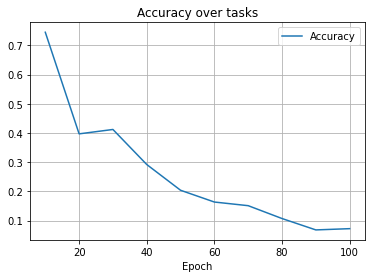

In [ ]:
plotTask(l)